In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import seaborn as sns
import os

from scipy.optimize import least_squares
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy import stats

from scipy.optimize import curve_fit

In [2]:
#Importing curated tracks (removed bad tracks)
filepath = r'.\curated tracks\currated tracks'
all_files = os.listdir(filepath)

In [115]:

#Make dataframe. This is going to hold all of ABs data.
df = pd.DataFrame(columns=['FILENAME','PRIME_STATE','TRACK_ID','MOMENTS','MSS_SLOPE','DIFFUSION_COEF','DIFFUSION_COEF_2ND_ORDER','DIFFUSION_TYPE'])

#Initialize arrays for storing moment scaling spectrum information
FILENAME = []
PRIME_STATE = []
TRACK_ID = []
MOMENT_FITS = []
MSS = []
DIFFUSION_TYPE = []
DIFFUSION_COEF = []
DIFFUSION_COEFF_2 = []

#Read in all files
for i in all_files:
    #Get the first file
    data = pd.read_csv(filepath + r'\\' + i)
    #Get all of the unique track IDs
    TRACKS = np.unique(data['TRACK_ID'].astype('int'))
    for j in TRACKS:
        #Get a singular track
        data_for_track_id = data[data['TRACK_ID']==j]
        TRACK_ID.append(j)
        
        #Get the initial X and Y position 
        X_0 = data_for_track_id['POSITION_X'].iloc[0]
        Y_0 = data_for_track_id['POSITION_Y'].iloc[0]
        
        #Get all the X positions for the track
        ALL_X = np.asarray((data_for_track_id['POSITION_X']))
        ALL_Y = np.asarray((data_for_track_id['POSITION_Y']))
        
        #Center the X and Y positions
        CENTERED_X = ALL_X - X_0
        CENTERED_Y = ALL_Y - Y_0
        
        #Calculate radial positions
        CENTERED_R = np.sqrt(((CENTERED_X)**2) + ((CENTERED_Y)**2))
        
        #Center the times. Start them from T=0 for all. 
        CENTERED_T = np.asarray((data_for_track_id['POSITION_T'])-data_for_track_id['POSITION_T'].iloc[0])
        #Time between each point
        DELTA_T = np.mean(np.diff(CENTERED_T))
        TOTAL_NUMBER_OF_POINTS = np.shape(CENTERED_T)[0]
        #Need max step for moment formula
        MAX_STEP = int(TOTAL_NUMBER_OF_POINTS/3)
        
        #Calculate all of the moments for the current track and store them in this list. 
        ALL_MOMENT_FITS = []
        
        #Calculate all the diffusion coefficent for the current track and store them in this list.
        ALL_DIFFUSION = []
        
        #Calculate all the 2nd order diffusion coefficents
        ALL_DIFFUSION_2 = []
        
        for k in range(7):
            #Make a new list to store all of the different values the moment takes based on the current frameshift.
            #We need this list to plot the different values of the moment against the frameshift
            CURRENT_MOMENT = []
            CURRENT_FRAMESTEPS = []
            for deln in range(1,MAX_STEP+1):
                #Calculate constant for calculating moment
                A = (1/(TOTAL_NUMBER_OF_POINTS-deln))
                #Get the range of points we need to loop over
                FRAMESHIFT_SUM_LEN = TOTAL_NUMBER_OF_POINTS-1-deln
                #Make a list to store the differences
                frameshift_differences = []
                for m in range(FRAMESHIFT_SUM_LEN):
                    frameshift_differences.append(abs((CENTERED_R[m+deln]-CENTERED_R[m]))**k)
                #Append the moment which is the sum of the frameshift differences times the A constant 
                CURRENT_MOMENT.append(A*sum(frameshift_differences))
                #Append the frameshift, er, framestep. Fine, whatever. To the framestep list.
                CURRENT_FRAMESTEPS.append(deln)
            #Perform least square fit to moment line in log-log space.
            #To do this, I need to take the log of x and y.
            #Y in this case is the moment.
            #X is the frameshift/framestep times delta T
            CURRENT_MOMENT = np.log(np.asarray(CURRENT_MOMENT))
            CURRENT_DELTA_T = np.log(np.asarray(CURRENT_FRAMESTEPS)*DELTA_T)
            A = np.vstack([CURRENT_DELTA_T, np.ones(len(CURRENT_DELTA_T))]).T
            m, c = np.linalg.lstsq(A, CURRENT_MOMENT, rcond=None)[0]
            
            
            #Now, this slope should be the slope of log(MN)=GAMMA*NU*log(delta_T)
            #We know that Nu is the order of the moment so, if I just divide the slope by Nu, I should have gamma
            #I made the strict condition that at order zero, or the zeroth moment, gamma is zero. 
            #It was obvious to me from the slopes I got when I just set gamma=m that the slope was trying to be zero
            #But I think Numpy was still doing it best to fit 
            if k==0:
                gamma = 0
            else:
                gamma = m/k
            
            #Diffusion coeff
            D = 1/4*np.exp(c)
            #Now I want to append gamma to the all moments fit list I made before this loop.
            #This loop will contain all of the gamma fits so I can create the MSS and find its slope
            ALL_MOMENT_FITS.append(gamma)
            ALL_DIFFUSION.append(D)
            if k==2:
                ALL_DIFFUSION_2.append(D)
        #Now, I need to fit the list of all moments to a line
        ORDERS = np.asarray([0,1,2,3,4,5,6])
        #All of the slopes I got from fitting each moment
        ALL_MOMENT_FITS = np.asarray(ALL_MOMENT_FITS)
        A = np.vstack([ORDERS, np.ones(len(ORDERS))]).T
        #Now, fit a line to all of the calculated motion moments. Slope of this line is the MSS value 
        #Used to characterized motion
        MSS_SLOPE, _ = np.linalg.lstsq(A, ALL_MOMENT_FITS, rcond=0)[0]
        
        #Append the filename to list of filenames
        FILENAME.append(filepath + r'\\' + i)
        
        #Append prime or unprime state to list of prime states
        PRIME = None
        if i.startswith('primed'):
            PRIME = 'PRIMED'
        else:
            PRIME = 'UNPRIMED'
        PRIME_STATE.append(PRIME)
        
        #Append the list of moment fits to the moment fit list
        MOMENT_FITS.append(ALL_MOMENT_FITS)
        
        #Append the list of diffusion coefs to the coef list
        ALL_DIFFUSION = np.asarray(ALL_DIFFUSION)
        DIFFUSION_COEF.append(ALL_DIFFUSION)
        DIFFUSION_COEFF_2.append(ALL_DIFFUSION_2)
        
        
        #Append the MSS slope to the MSS list
        MSS.append(MSS_SLOPE)
        
        #SJR cuts for diffusion type. Just from what I observed. Feel free to make your own cuts. Not all values are perfectly
        #At zero. Some are order 10^-2 and some are order 10^-3. 10^-2 are subdiffuse and 10^-3 are stationary.
        if MSS_SLOPE < 0.01:
            DIFFUSION_TYPE.append('STATIONARY')
        else:
            DIFFUSION_TYPE.append('SUBDIFFUSE')
            
#Create the dataframe
df['TRACK_ID']=np.asarray(TRACK_ID).T
df['PRIME_STATE']=np.asarray(PRIME_STATE).T
df['FILENAME']=np.asarray(FILENAME).T
df['MOMENTS']=MOMENT_FITS
df['MSS_SLOPE']=np.asarray(MSS).T
df['DIFFUSION_TYPE']=np.asarray(DIFFUSION_TYPE).T 
df['DIFFUSION_COEF']=DIFFUSION_COEF
df['DIFFUSION_COEF_2ND_ORDER']=np.asarray(DIFFUSION_COEFF_2)

In [116]:
df
#Also get diffusion coefficent 
#Get Dv = 1/4*ey0 for order==2. 

,FILENAME,PRIME_STATE,TRACK_ID,MOMENTS,MSS_SLOPE,DIFFUSION_COEF,DIFFUSION_COEF_2ND_ORDER,DIFFUSION_TYPE
0,E:\20230904_AB_Data\curated tracks\currated tr...,PRIMED,2,"[0.0, 0.17422738598836685, 0.13239525001619212...",-0.002749,"[0.2493725859253358, 0.029693936093862294, 0.0...",0.006485,STATIONARY
1,E:\20230904_AB_Data\curated tracks\currated tr...,PRIMED,8,"[0.0, 0.538462219966692, 0.5181106934070303, 0...",0.042208,"[0.2474223303126862, 0.05428833115421578, 0.02...",0.021582,SUBDIFFUSE
2,E:\20230904_AB_Data\curated tracks\currated tr...,PRIMED,11,"[0.0, 0.4435668647714103, 0.41310970269733327,...",0.025575,"[0.24955544872710092, 0.03246359203806699, 0.0...",0.010283,SUBDIFFUSE
3,E:\20230904_AB_Data\curated tracks\currated tr...,PRIMED,13,"[0.0, 0.28607848002409925, 0.2691704651203334,...",0.021665,"[0.24617541171533433, 0.07632260879219702, 0.0...",0.035759,SUBDIFFUSE
4,E:\20230904_AB_Data\curated tracks\currated tr...,PRIMED,14,"[0.0, 0.2172822398953406, 0.2216814509399322, ...",0.027831,"[0.2490966715185475, 0.06648410068127632, 0.02...",0.027399,SUBDIFFUSE
...,...,...,...,...,...,...,...,...
315,E:\20230904_AB_Data\curated tracks\currated tr...,UNPRIMED,324,"[0.0, 0.42144908274557363, 0.4297508656748753,...",0.038886,"[0.24689674244956525, 0.03428277926275871, 0.0...",0.008132,SUBDIFFUSE
316,E:\20230904_AB_Data\curated tracks\currated tr...,UNPRIMED,333,"[0.0, 0.42476792375597094, 0.36689984809944015...",0.016794,"[0.24774880174176933, 0.04386549334801131, 0.0...",0.012253,SUBDIFFUSE
317,E:\20230904_AB_Data\curated tracks\currated tr...,UNPRIMED,565,"[0.0, 0.5312757007818079, 0.5402253752103143, ...",0.055459,"[0.2475823363180824, 0.01194614728678712, 0.00...",0.000908,SUBDIFFUSE
318,E:\20230904_AB_Data\curated tracks\currated tr...,UNPRIMED,567,"[0.0, 0.15909578023187443, 0.1611983431578992,...",0.017543,"[0.24742248010086618, 0.03887736824727814, 0.0...",0.009312,SUBDIFFUSE


In [117]:
df.to_csv('20231108_Moment_Scaling_Spectrum_for_AB.csv')

In [77]:
#Just checking population differences 
#On a per image level
PRIMED_DATA = df[df['PRIME_STATE']=='PRIMED']
UNPRIMED_DATA = df[df['PRIME_STATE']=='UNPRIMED']

PRIMED_TOTAL = np.shape(PRIMED_DATA)[0]
UNPRIMED_TOTAL = np.shape(UNPRIMED_DATA)[0]

STATIONARY_PRIMED = sum(PRIMED_DATA['DIFFUSION_TYPE']=='STATIONARY')
DIFFUSE_PRIMED = sum(PRIMED_DATA['DIFFUSION_TYPE']=='SUBDIFFUSE')

STATIONARY_UNPRIMED = sum(UNPRIMED_DATA['DIFFUSION_TYPE']=='STATIONARY')
DIFFUSE_UNPRIMED = sum(UNPRIMED_DATA['DIFFUSION_TYPE']=='SUBDIFFUSE')

print('Primed Stationary Pop. Percent: ', STATIONARY_PRIMED/PRIMED_TOTAL)
print('Primed Subdiffuse Pop. Percent: ', DIFFUSE_PRIMED/PRIMED_TOTAL)

print('UnPrimed Stationary Pop. Percent: ', STATIONARY_UNPRIMED/UNPRIMED_TOTAL)
print('UnPrimed Subdiffuse Pop. Percent: ', DIFFUSE_UNPRIMED/UNPRIMED_TOTAL)

#Ok so there is some differences

Primed Stationary Pop. Percent:  0.11042944785276074
Primed Subdiffuse Pop. Percent:  0.8895705521472392
UnPrimed Stationary Pop. Percent:  0.2484076433121019
UnPrimed Subdiffuse Pop. Percent:  0.7515923566878981


In [79]:
#Let's just check and make sure these cuts and everything just makes sense

STATIONARY


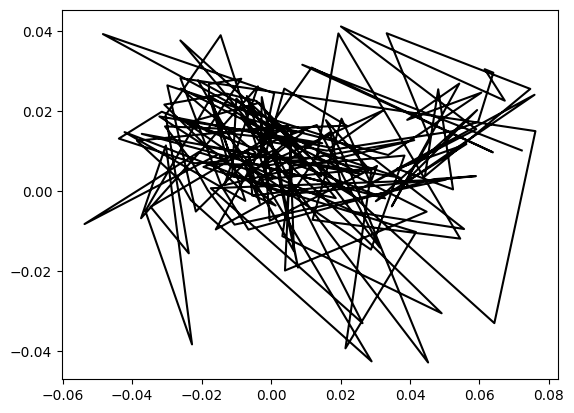

In [159]:
import random 
RANDOM_FILE_TO_PLOT = df.iloc[random.randint(0,319)]

data = pd.read_csv(RANDOM_FILE_TO_PLOT['FILENAME'])
data_for_track_id = data[data['TRACK_ID']==RANDOM_FILE_TO_PLOT['TRACK_ID']]

print(RANDOM_FILE_TO_PLOT['DIFFUSION_TYPE'])

#Get the initial X and Y position 
X_0 = data_for_track_id['POSITION_X'].iloc[0]
Y_0 = data_for_track_id['POSITION_Y'].iloc[0]
        
#Get all the X positions for the track
ALL_X = np.asarray((data_for_track_id['POSITION_X']))
ALL_Y = np.asarray((data_for_track_id['POSITION_Y']))
        
#Center the X and Y positions
CENTERED_X = ALL_X - X_0
CENTERED_Y = ALL_Y - Y_0
        
#Calculate radial positions
CENTERED_R = np.sqrt(((CENTERED_X)**2) + ((CENTERED_Y)**2))

plt.figure()
plt.plot(CENTERED_X,CENTERED_Y,color='k')

In [132]:
#Getting population splits per file
df_2 = pd.DataFrame(columns=['FILENAME','PERCENT_CONFINED','PERCENT_FREE'])
LIST_OF_FILENAMES = np.unique(df['FILENAME'])

FILENAMES = []
PERCENT_CONFINED = []
PERCENT_FREE = []
DIFFUSION_COEF = []

for i in LIST_OF_FILENAMES:
    CURRENT_FILE = df[df['FILENAME']==i]
    TOTAL_TRACKS = np.shape(CURRENT_FILE['DIFFUSION_TYPE'])[0]
    CONFINED_PERCENT = sum(CURRENT_FILE['DIFFUSION_TYPE']=='STATIONARY')/TOTAL_TRACKS
    FREE_PERCENT = sum(CURRENT_FILE['DIFFUSION_TYPE']=='SUBDIFFUSE')/TOTAL_TRACKS
    FILENAMES.append(i)
    PERCENT_CONFINED.append(CONFINED_PERCENT)
    PERCENT_FREE.append(FREE_PERCENT)
    print(i)
    
df_2['FILENAME']=np.asarray(FILENAMES)
df_2['PERCENT_CONFINED']=np.asarray(PERCENT_CONFINED)
df_2['PERCENT_FREE']=np.asarray(PERCENT_FREE)
    

E:\20230904_AB_Data\curated tracks\currated tracks\\primedB02_010.csv
E:\20230904_AB_Data\curated tracks\currated tracks\\primedC08_006.csv
E:\20230904_AB_Data\curated tracks\currated tracks\\primedG02_000.csv
E:\20230904_AB_Data\curated tracks\currated tracks\\primedG02_001.csv
E:\20230904_AB_Data\curated tracks\currated tracks\\primedG02_002.csv
E:\20230904_AB_Data\curated tracks\currated tracks\\primedG02_003.csv
E:\20230904_AB_Data\curated tracks\currated tracks\\primedG02_004.csv
E:\20230904_AB_Data\curated tracks\currated tracks\\primedG02_005.csv
E:\20230904_AB_Data\curated tracks\currated tracks\\primedG02_006.csv
E:\20230904_AB_Data\curated tracks\currated tracks\\primedG02_008.csv
E:\20230904_AB_Data\curated tracks\currated tracks\\primedG02_009.csv
E:\20230904_AB_Data\curated tracks\currated tracks\\primedG02_010.csv
E:\20230904_AB_Data\curated tracks\currated tracks\\primedG02_011.csv
E:\20230904_AB_Data\curated tracks\currated tracks\\primedG02_012.csv
E:\20230904_AB_Data\

In [126]:
df_2

,FILENAME,PERCENT_CONFINED,PERCENT_FREE
0,E:\20230904_AB_Data\curated tracks\currated tr...,0.125000,0.875000
1,E:\20230904_AB_Data\curated tracks\currated tr...,0.000000,1.000000
2,E:\20230904_AB_Data\curated tracks\currated tr...,0.136364,0.863636
3,E:\20230904_AB_Data\curated tracks\currated tr...,0.000000,1.000000
4,E:\20230904_AB_Data\curated tracks\currated tr...,0.000000,1.000000
5,E:\20230904_AB_Data\curated tracks\currated tr...,0.000000,1.000000
6,E:\20230904_AB_Data\curated tracks\currated tr...,0.250000,0.750000
7,E:\20230904_AB_Data\curated tracks\currated tr...,0.125000,0.875000
8,E:\20230904_AB_Data\curated tracks\currated tr...,0.333333,0.666667
9,E:\20230904_AB_Data\curated tracks\currated tr...,0.222222,0.777778


In [129]:
#Saving the CSV
df_2.to_csv('20231109_Percent_Free_and_Confined.csv')

C:\Users\sjrru\AppData\Local\Temp\ipykernel_11664\1598074040.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


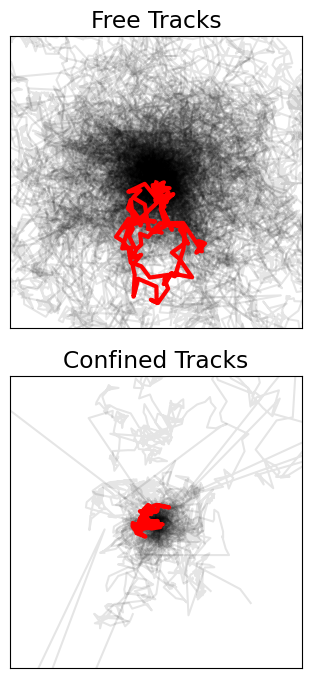

In [246]:
##Plotting all of the tracks on top of one another 
FREE_TRACK = df[df['DIFFUSION_TYPE']=='SUBDIFFUSE']
CONFINED_TRACK = df[df['DIFFUSION_TYPE']=='STATIONARY']

TOTAL_FREE = np.shape(FREE_TRACK)[0]
TOTAL_CONFINED = np.shape(CONFINED_TRACK)[0]

LUCK_FREE = random.randint(0,TOTAL_FREE-1)
LUCK_CONFINED = random.randint(0,TOTAL_CONFINED-1)

plt.subplot(211,aspect='equal')
#Plot all free tracks on top of each other
for i in range(np.shape(FREE_TRACK)[0]):
    TO_PLOT = FREE_TRACK.iloc[i]
    data = pd.read_csv(TO_PLOT['FILENAME'])
    data_for_track_id = data[data['TRACK_ID']==TO_PLOT['TRACK_ID']]
    
    #Get the initial X and Y position 
    X_0 = data_for_track_id['POSITION_X'].iloc[0]
    Y_0 = data_for_track_id['POSITION_Y'].iloc[0]
        
    #Get all the X positions for the track
    ALL_X = np.asarray((data_for_track_id['POSITION_X']))
    ALL_Y = np.asarray((data_for_track_id['POSITION_Y']))
        
    #Center the X and Y positions
    CENTERED_X = ALL_X - X_0
    CENTERED_Y = ALL_Y - Y_0
    
    color='k'
    alpha=0.1
    
    
    plt.plot(CENTERED_X,CENTERED_Y,alpha=alpha,color=color)

#Picking one free track to highlight in red (called lucky because it was picked as a featured track!)
TO_PLOT = FREE_TRACK.iloc[LUCK_FREE]
data = pd.read_csv(TO_PLOT['FILENAME'])
data_for_track_id = data[data['TRACK_ID']==TO_PLOT['TRACK_ID']]
    
#Get the initial X and Y position 
X_0 = data_for_track_id['POSITION_X'].iloc[0]
Y_0 = data_for_track_id['POSITION_Y'].iloc[0]
        
#Get all the X positions for the track
ALL_X = np.asarray((data_for_track_id['POSITION_X']))
ALL_Y = np.asarray((data_for_track_id['POSITION_Y']))
        
#Center the X and Y positions
CENTERED_X = ALL_X - X_0
CENTERED_Y = ALL_Y - Y_0

#Plotting the highlighted track in red
plt.plot(CENTERED_X,CENTERED_Y,alpha=1,color='r',linewidth=3)    
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.yticks([])
plt.xticks([])
plt.rcParams["figure.figsize"] = (7,7)
plt.title('Free Tracks')
plt.tight_layout()
plt.rc('font', size=14) 

#Repeating the same process but for the confined tracks
plt.subplot(212,aspect='equal')
for i in range(np.shape(CONFINED_TRACK)[0]):
    TO_PLOT = CONFINED_TRACK.iloc[i]
    data = pd.read_csv(TO_PLOT['FILENAME'])
    data_for_track_id = data[data['TRACK_ID']==TO_PLOT['TRACK_ID']]
    
    #Get the initial X and Y position 
    X_0 = data_for_track_id['POSITION_X'].iloc[0]
    Y_0 = data_for_track_id['POSITION_Y'].iloc[0]
        
    #Get all the X positions for the track
    ALL_X = np.asarray((data_for_track_id['POSITION_X']))
    ALL_Y = np.asarray((data_for_track_id['POSITION_Y']))
        
    #Center the X and Y positions
    CENTERED_X = ALL_X - X_0
    CENTERED_Y = ALL_Y - Y_0
    
    color='k'
    alpha=0.1
    

    plt.plot(CENTERED_X,CENTERED_Y,alpha=alpha,color=color)

TO_PLOT = CONFINED_TRACK.iloc[LUCK_CONFINED]
data = pd.read_csv(TO_PLOT['FILENAME'])
data_for_track_id = data[data['TRACK_ID']==TO_PLOT['TRACK_ID']]
    
    #Get the initial X and Y position 
X_0 = data_for_track_id['POSITION_X'].iloc[0]
Y_0 = data_for_track_id['POSITION_Y'].iloc[0]
        
    #Get all the X positions for the track
ALL_X = np.asarray((data_for_track_id['POSITION_X']))
ALL_Y = np.asarray((data_for_track_id['POSITION_Y']))
        
    #Center the X and Y positions
CENTERED_X = ALL_X - X_0
CENTERED_Y = ALL_Y - Y_0

plt.plot(CENTERED_X,CENTERED_Y,alpha=1,color='r',linewidth=3)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
#plt.rcParams["figure.figsize"] = (5,5)
plt.title('Confined Tracks')
plt.yticks([])
plt.xticks([])
plt.tight_layout()
plt.rc('font', size=14) 

    



C:\Users\sjrru\AppData\Local\Temp\ipykernel_11664\4219273998.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


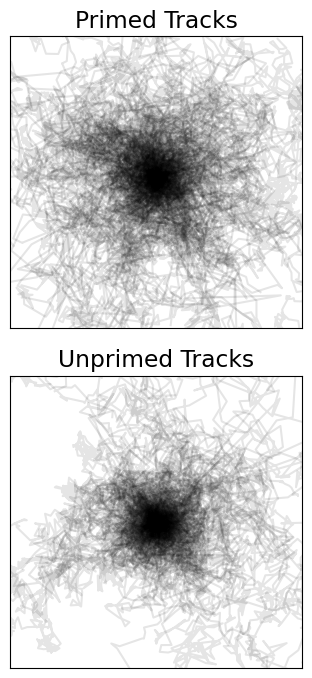

In [250]:
#This is just a repeat of what I did above without the track being highlighted in red

##Plotting all of the tracks on top of one another 
FREE_TRACK = df[df['PRIME_STATE']=='PRIMED']
CONFINED_TRACK = df[df['PRIME_STATE']=='UNPRIMED']

TOTAL_FREE = np.shape(FREE_TRACK)[0]
TOTAL_CONFINED = np.shape(CONFINED_TRACK)[0]

LUCK_FREE = random.randint(0,TOTAL_FREE-1)
LUCK_CONFINED = random.randint(0,TOTAL_CONFINED-1)

plt.subplot(211,aspect='equal')
#Plot all free tracks on top of each other
for i in range(np.shape(FREE_TRACK)[0]):
    TO_PLOT = FREE_TRACK.iloc[i]
    data = pd.read_csv(TO_PLOT['FILENAME'])
    data_for_track_id = data[data['TRACK_ID']==TO_PLOT['TRACK_ID']]
    
    #Get the initial X and Y position 
    X_0 = data_for_track_id['POSITION_X'].iloc[0]
    Y_0 = data_for_track_id['POSITION_Y'].iloc[0]
        
    #Get all the X positions for the track
    ALL_X = np.asarray((data_for_track_id['POSITION_X']))
    ALL_Y = np.asarray((data_for_track_id['POSITION_Y']))
        
    #Center the X and Y positions
    CENTERED_X = ALL_X - X_0
    CENTERED_Y = ALL_Y - Y_0
    
    color='k'
    alpha=0.1
    
    
    plt.plot(CENTERED_X,CENTERED_Y,alpha=alpha,color=color)


plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.yticks([])
plt.xticks([])
plt.rcParams["figure.figsize"] = (7,7)
plt.title('Primed Tracks')
plt.tight_layout()
plt.rc('font', size=14) 

plt.subplot(212,aspect='equal')
for i in range(np.shape(CONFINED_TRACK)[0]):
    TO_PLOT = CONFINED_TRACK.iloc[i]
    data = pd.read_csv(TO_PLOT['FILENAME'])
    data_for_track_id = data[data['TRACK_ID']==TO_PLOT['TRACK_ID']]
    
    #Get the initial X and Y position 
    X_0 = data_for_track_id['POSITION_X'].iloc[0]
    Y_0 = data_for_track_id['POSITION_Y'].iloc[0]
        
    #Get all the X positions for the track
    ALL_X = np.asarray((data_for_track_id['POSITION_X']))
    ALL_Y = np.asarray((data_for_track_id['POSITION_Y']))
        
    #Center the X and Y positions
    CENTERED_X = ALL_X - X_0
    CENTERED_Y = ALL_Y - Y_0
    
    color='k'
    alpha=0.1
    

    plt.plot(CENTERED_X,CENTERED_Y,alpha=alpha,color=color)



plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
#plt.rcParams["figure.figsize"] = (25,25)
plt.title('Unprimed Tracks')
plt.yticks([])
plt.xticks([])
plt.tight_layout()
plt.rc('font', size=14) 
